# <font color=red>Data Challenge: "Stock trading: prediction of auction volumes" by CFM</font> 

## <font color=blue>Importation des modules/fonctions nécessaires</font> 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import time
import itertools

In [2]:
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras.layers import Dense, Activation, LSTM, Input
from tensorflow.keras.models import Sequential
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor

## <font color=blue>Importation des données d'entraînement</font> 

In [ ]:
X_untouched = pd.read_csv(r"/Users/ayaamenssag/Desktop/input_training.csv", index_col=0)
Y_untouched = pd.read_csv(r"/Users/ayaamenssag/Desktop/output_training_IxKGwDV.csv", index_col=0)

In [4]:
X_untouched.head()

,pid,day,abs_ret0,abs_ret1,abs_ret2,abs_ret3,abs_ret4,abs_ret5,abs_ret6,abs_ret7,abs_ret8,abs_ret9,abs_ret10,abs_ret11,abs_ret12,abs_ret13,abs_ret14,abs_ret15,abs_ret16,abs_ret17,abs_ret18,abs_ret19,abs_ret20,abs_ret21,abs_ret22,abs_ret23,abs_ret24,abs_ret25,abs_ret26,abs_ret27,abs_ret28,abs_ret29,abs_ret30,abs_ret31,abs_ret32,abs_ret33,abs_ret34,abs_ret35,abs_ret36,abs_ret37,...,rel_vol23,rel_vol24,rel_vol25,rel_vol26,rel_vol27,rel_vol28,rel_vol29,rel_vol30,rel_vol31,rel_vol32,rel_vol33,rel_vol34,rel_vol35,rel_vol36,rel_vol37,rel_vol38,rel_vol39,rel_vol40,rel_vol41,rel_vol42,rel_vol43,rel_vol44,rel_vol45,rel_vol46,rel_vol47,rel_vol48,rel_vol49,rel_vol50,rel_vol51,rel_vol52,rel_vol53,rel_vol54,rel_vol55,rel_vol56,rel_vol57,rel_vol58,rel_vol59,rel_vol60,LS,NLV
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
148,360,0,0.000000,0.000000,0.0,0.000000,0.029317,0.000000,0.000000,0.000000,0.000000,0.073260,0.073265,0.0,0.036601,0.102399,0.029261,0.00000,0.073206,0.032942,0.036609,0.000000,0.014641,0.036643,0.0,0.036630,0.007326,0.000000,0.0,0.000000,0.000000,0.000000,0.014656,0.000000,0.000000,0.000000,0.0,0.021989,0.036627,0.018305,...,0.019147,0.023043,0.010204,0.015254,0.006455,0.006221,0.007477,0.015452,0.005510,0.014621,0.004915,0.009695,0.014404,0.011438,0.005018,0.003520,0.006112,0.001629,0.007395,0.007272,0.017971,0.007965,0.003240,0.008937,0.008786,0.009677,0.008480,0.011040,0.004054,0.009431,0.004521,0.015771,0.009462,0.012697,0.019507,0.005101,0.010654,0.006971,-2.307230,0.646580
149,360,1,0.000000,0.000000,0.0,0.022056,0.000000,0.036711,0.000000,0.000000,0.036767,0.000000,0.058949,0.0,0.014700,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.014743,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.014802,0.014818,0.000000,0.000000,0.022168,0.000000,0.0,0.000000,0.051764,0.000000,...,0.007153,0.010241,0.005084,0.010341,0.009629,0.008034,0.012606,0.022932,0.002855,0.010928,0.004953,0.001122,0.007357,0.032969,0.004212,0.004200,0.002189,0.004183,0.000931,0.000753,0.008522,0.011424,0.042281,0.003987,0.002132,0.003802,0.003952,0.009427,0.017466,0.023188,0.008817,0.006589,0.005276,0.011648,0.011829,0.015558,0.001788,0.005251,-2.263960,0.487708
150,360,2,0.000000,0.000000,0.0,0.000000,0.022267,0.000000,0.029678,0.014831,0.048146,0.092654,0.000000,NaN,0.000000,0.051902,0.000000,0.02227,0.000000,0.118457,0.059084,0.000000,0.000000,0.014806,0.0,0.022166,0.000000,0.000000,0.0,0.000000,0.029588,0.044418,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.008215,0.015199,0.007220,0.007814,0.003919,0.012528,0.005863,0.008573,0.009908,0.004453,0.007961,0.003208,0.006635,0.002473,0.001524,0.007806,0.002231,0.006975,0.004943,0.002252,0.007676,0.022513,0.124384,0.017086,0.023940,0.036648,0.025713,0.020880,0.009542,0.006752,0.018640,0.020972,0.012728,0.007921,0.000643,0.029692,0.016440,0.011970,-2.343106,0.544476
151,360,3,0.000000,0.007384,0.0,0.000000,0.000000,0.007417,0.000000,0.044557,0.052169,0.044613,0.000000,0.0,0.000000,0.000000,0.007423,0.00000,0.000000,0.007447,0.000000,0.000000,0.007418,0.000000,0.0,0.000000,0.000000,0.007389,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007362,0.0,0.000000,0.036824,0.000000,...,0.003782,0.029602,0.013475,0.031606,0.007952,0.021086,0.010731,0.025026,0.004192,0.009762,0.016240,0.012835,0.008973,0.023312,0.003007,0.009878,0.011719,0.009139,0.006265,0.010273,0.012355,0.011745,0.001635,0.005562,0.007811,0.010685,0.062768,0.072686,0.009503,0.017088,0.013628,0.020397,0.016834,0.031869,0.012468,0.065173,0.048286,0.021237,-2.331621,0.633181
152,360,4,0.088086,0.109737,0.0,0.014648,0.003662,0.036627,0.007319,0.197325,0.094835,0.029218,0.000000,0.0,0.000000,0.050850,0.000000,0.00000,0.098100,0.058245,0.007266,0.018169,0.007283,0.014541,0.0,0.000000,0.000000,0.000000,0.0,0.076542,0.182548,0.000000,0.051136,0.007305,0.000000,0.000000,0.0,0.051230,0.036611,0.000000,...,0.008732,0.009927,0.006543,0.043907,0.015489,0.03943

In [5]:
Y_untouched.head()

,target
ID,
148,-3.403606
149,-2.904798
150,-2.337807
151,-2.285676
152,-2.606321


***On regarde les dimensions de notre dataset:***

In [6]:
print(X_untouched.shape, Y_untouched.shape)

(684482, 126) (684482, 1)


***Notre jeu de données contient donc 684482 observations et 126 features (pid, day, abs_retn, rel_voln, LS et NLV), on essaie de prédire la donnée 'target'.***

## <font color=blue>Prétraîtement des données d'entraînement</font> 


***On va enlever la colonne 'pid parce que c'est une donnée catégorielle:***

In [7]:
columns_to_scale = [s for s in X_untouched.columns]
columns_to_scale.remove('pid')
#Pour simplifier, on appellera X0 le dataset intact (avec la colonne 'pid')
X0 = X_untouched

#La commande ci-dessous reste commentée, on en aura besoin pour une partie ultérieure
#X0[columns_to_scale] = StandardScaler().fit_transform(X0[columns_to_scale])

In [8]:
X0

,pid,day,abs_ret0,abs_ret1,abs_ret2,abs_ret3,abs_ret4,abs_ret5,abs_ret6,abs_ret7,abs_ret8,abs_ret9,abs_ret10,abs_ret11,abs_ret12,abs_ret13,abs_ret14,abs_ret15,abs_ret16,abs_ret17,abs_ret18,abs_ret19,abs_ret20,abs_ret21,abs_ret22,abs_ret23,abs_ret24,abs_ret25,abs_ret26,abs_ret27,abs_ret28,abs_ret29,abs_ret30,abs_ret31,abs_ret32,abs_ret33,abs_ret34,abs_ret35,abs_ret36,abs_ret37,...,rel_vol23,rel_vol24,rel_vol25,rel_vol26,rel_vol27,rel_vol28,rel_vol29,rel_vol30,rel_vol31,rel_vol32,rel_vol33,rel_vol34,rel_vol35,rel_vol36,rel_vol37,rel_vol38,rel_vol39,rel_vol40,rel_vol41,rel_vol42,rel_vol43,rel_vol44,rel_vol45,rel_vol46,rel_vol47,rel_vol48,rel_vol49,rel_vol50,rel_vol51,rel_vol52,rel_vol53,rel_vol54,rel_vol55,rel_vol56,rel_vol57,rel_vol58,rel_vol59,rel_vol60,LS,NLV
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
148,360,0,0.000000,0.000000,0.000000,0.000000,0.029317,0.000000,0.000000,0.000000,0.000000,0.073260,0.073265,0.000000,0.036601,0.102399,0.029261,0.000000,0.073206,0.032942,0.036609,0.000000,0.014641,0.036643,0.000000,0.036630,0.007326,0.000000,0.000000,0.000000,0.000000,0.000000,0.014656,0.000000,0.000000,0.000000,0.000000,0.021989,0.036627,0.018305,...,0.019147,0.023043,0.010204,0.015254,0.006455,0.006221,0.007477,0.015452,0.005510,0.014621,0.004915,0.009695,0.014404,0.011438,0.005018,0.003520,0.006112,0.001629,0.007395,0.007272,0.017971,0.007965,0.003240,0.008937,0.008786,0.009677,0.008480,0.011040,0.004054,0.009431,0.004521,0.015771,0.009462,0.012697,0.019507,0.005101,0.010654,0.006971,-2.307230,0.646580
149,360,1,0.000000,0.000000,0.000000,0.022056,0.000000,0.036711,0.000000,0.000000,0.036767,0.000000,0.058949,0.000000,0.014700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014743,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014802,0.014818,0.000000,0.000000,0.022168,0.000000,0.000000,0.000000,0.051764,0.000000,...,0.007153,0.010241,0.005084,0.010341,0.009629,0.008034,0.012606,0.022932,0.002855,0.010928,0.004953,0.001122,0.007357,0.032969,0.004212,0.004200,0.002189,0.004183,0.000931,0.000753,0.008522,0.011424,0.042281,0.003987,0.002132,0.003802,0.003952,0.009427,0.017466,0.023188,0.008817,0.006589,0.005276,0.011648,0.011829,0.015558,0.001788,0.005251,-2.263960,0.487708
150,360,2,0.000000,0.000000,0.000000,0.000000,0.022267,0.000000,0.029678,0.014831,0.048146,0.092654,0.000000,NaN,0.000000,0.051902,0.000000,0.022270,0.000000,0.118457,0.059084,0.000000,0.000000,0.014806,0.000000,0.022166,0.000000,0.000000,0.000000,0.000000,0.029588,0.044418,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.008215,0.015199,0.007220,0.007814,0.003919,0.012528,0.005863,0.008573,0.009908,0.004453,0.007961,0.003208,0.006635,0.002473,0.001524,0.007806,0.002231,0.006975,0.004943,0.002252,0.007676,0.022513,0.124384,0.017086,0.023940,0.036648,0.025713,0.020880,0.009542,0.006752,0.018640,0.020972,0.012728,0.007921,0.000643,0.029692,0.016440,0.011970,-2.343106,0.544476
151,360,3,0.000000,0.007384,0.000000,0.000000,0.000000,0.007417,0.000000,0.044557,0.052169,0.044613,0.000000,0.000000,0.000000,0.000000,0.007423,0.000000,0.000000,0.007447,0.000000,0.000000,0.007418,0.000000,0.000000,0.000000,0.000000,0.007389,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007362,0.000000,0.000000,0.036824,0.000000,...,0.003782,0.029602,0.013475,0.031606,0.007952,0.021086,0.010731,0.025026,0.004192,0.009762,0.016240,0.012835,0.008973,0.023312,0.003007,0.009878,0.011719,0.009139,0.006265,0.010273,0.012355,0.011745,0.001635,0.005562,0.007811,0.010685,0.062768,0.072686,0.009503,0.017088,0.013628,0.020397,0.016834,0.031869,0.012468,0.065173,0.048286,0.021237,-2.331621,0.633181
152,360,4,0.088086,0.109737,0.000000,0.014648,0.003662,0.036627,0.007319,0.197325,0.094835,0.029218,0.000000,0.000000,0.000000,0.050850,0.000000,0.000000,0.098100,0.058245,0.007266,0.018169,0.007283,0.014541,0.000000,0.000000,0.000000,0.000000,0.000000,0.076542,0.182548,0.000000,0.0

***On remarque que certaines données manquent sur notre dataset, donc on va les remplacer par des zéros:***

In [9]:
#On appellera X les données d'entraînement sans la colonne 'pid'
X0 = X0.fillna(0)
X = X0[columns_to_scale]
Y = Y_untouched.fillna(0)

In [10]:
X.head(5)

,day,abs_ret0,abs_ret1,abs_ret2,abs_ret3,abs_ret4,abs_ret5,abs_ret6,abs_ret7,abs_ret8,abs_ret9,abs_ret10,abs_ret11,abs_ret12,abs_ret13,abs_ret14,abs_ret15,abs_ret16,abs_ret17,abs_ret18,abs_ret19,abs_ret20,abs_ret21,abs_ret22,abs_ret23,abs_ret24,abs_ret25,abs_ret26,abs_ret27,abs_ret28,abs_ret29,abs_ret30,abs_ret31,abs_ret32,abs_ret33,abs_ret34,abs_ret35,abs_ret36,abs_ret37,abs_ret38,...,rel_vol23,rel_vol24,rel_vol25,rel_vol26,rel_vol27,rel_vol28,rel_vol29,rel_vol30,rel_vol31,rel_vol32,rel_vol33,rel_vol34,rel_vol35,rel_vol36,rel_vol37,rel_vol38,rel_vol39,rel_vol40,rel_vol41,rel_vol42,rel_vol43,rel_vol44,rel_vol45,rel_vol46,rel_vol47,rel_vol48,rel_vol49,rel_vol50,rel_vol51,rel_vol52,rel_vol53,rel_vol54,rel_vol55,rel_vol56,rel_vol57,rel_vol58,rel_vol59,rel_vol60,LS,NLV
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
148,0,0.000000,0.000000,0.0,0.000000,0.029317,0.000000,0.000000,0.000000,0.000000,0.073260,0.073265,0.0,0.036601,0.102399,0.029261,0.00000,0.073206,0.032942,0.036609,0.000000,0.014641,0.036643,0.0,0.036630,0.007326,0.000000,0.0,0.000000,0.000000,0.000000,0.014656,0.000000,0.000000,0.000000,0.0,0.021989,0.036627,0.018305,0.000000,...,0.019147,0.023043,0.010204,0.015254,0.006455,0.006221,0.007477,0.015452,0.005510,0.014621,0.004915,0.009695,0.014404,0.011438,0.005018,0.003520,0.006112,0.001629,0.007395,0.007272,0.017971,0.007965,0.003240,0.008937,0.008786,0.009677,0.008480,0.011040,0.004054,0.009431,0.004521,0.015771,0.009462,0.012697,0.019507,0.005101,0.010654,0.006971,-2.307230,0.646580
149,1,0.000000,0.000000,0.0,0.022056,0.000000,0.036711,0.000000,0.000000,0.036767,0.000000,0.058949,0.0,0.014700,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.014743,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.014802,0.014818,0.000000,0.000000,0.022168,0.000000,0.0,0.000000,0.051764,0.000000,0.000000,...,0.007153,0.010241,0.005084,0.010341,0.009629,0.008034,0.012606,0.022932,0.002855,0.010928,0.004953,0.001122,0.007357,0.032969,0.004212,0.004200,0.002189,0.004183,0.000931,0.000753,0.008522,0.011424,0.042281,0.003987,0.002132,0.003802,0.003952,0.009427,0.017466,0.023188,0.008817,0.006589,0.005276,0.011648,0.011829,0.015558,0.001788,0.005251,-2.263960,0.487708
150,2,0.000000,0.000000,0.0,0.000000,0.022267,0.000000,0.029678,0.014831,0.048146,0.092654,0.000000,0.0,0.000000,0.051902,0.000000,0.02227,0.000000,0.118457,0.059084,0.000000,0.000000,0.014806,0.0,0.022166,0.000000,0.000000,0.0,0.000000,0.029588,0.044418,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.008215,0.015199,0.007220,0.007814,0.003919,0.012528,0.005863,0.008573,0.009908,0.004453,0.007961,0.003208,0.006635,0.002473,0.001524,0.007806,0.002231,0.006975,0.004943,0.002252,0.007676,0.022513,0.124384,0.017086,0.023940,0.036648,0.025713,0.020880,0.009542,0.006752,0.018640,0.020972,0.012728,0.007921,0.000643,0.029692,0.016440,0.011970,-2.343106,0.544476
151,3,0.000000,0.007384,0.0,0.000000,0.000000,0.007417,0.000000,0.044557,0.052169,0.044613,0.000000,0.0,0.000000,0.000000,0.007423,0.00000,0.000000,0.007447,0.000000,0.000000,0.007418,0.000000,0.0,0.000000,0.000000,0.007389,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007362,0.0,0.000000,0.036824,0.000000,0.000000,...,0.003782,0.029602,0.013475,0.031606,0.007952,0.021086,0.010731,0.025026,0.004192,0.009762,0.016240,0.012835,0.008973,0.023312,0.003007,0.009878,0.011719,0.009139,0.006265,0.010273,0.012355,0.011745,0.001635,0.005562,0.007811,0.010685,0.062768,0.072686,0.009503,0.017088,0.013628,0.020397,0.016834,0.031869,0.012468,0.065173,0.048286,0.021237,-2.331621,0.633181
152,4,0.088086,0.109737,0.0,0.014648,0.003662,0.036627,0.007319,0.197325,0.094835,0.029218,0.000000,0.0,0.000000,0.050850,0.000000,0.00000,0.098100,0.058245,0.007266,0.018169,0.007283,0.014541,0.0,0.000000,0.000000,0.000000,0.0,0.076542,0.182548,0.000000,0.051136,0.007305,0.000000,0.000000,0.0,0.051230,0.036611,0.000000,0.007305,...,0.008732,0.009927,0.0

## <font color=blue>Importation et prétraîtement des données de test</font> 

In [ ]:
Xt_untouched = pd.read_csv(r"/Users/ayaamenssag/Desktop/input_test.csv",index_col=0)

In [ ]:
Xt_untouched

,pid,day,abs_ret0,abs_ret1,abs_ret2,abs_ret3,abs_ret4,abs_ret5,abs_ret6,abs_ret7,...,rel_vol53,rel_vol54,rel_vol55,rel_vol56,rel_vol57,rel_vol58,rel_vol59,rel_vol60,LS,NLV
ID,,,,,,,,,,,,,,,,,,,,,
1070752,360,805,0.318973,0.000000,0.036477,0.060808,0.121546,0.036420,0.020217,0.092986,...,0.005421,0.010815,0.008139,0.012176,0.014125,0.007319,0.010002,0.009969,-1.443817,0.666302
1070753,360,806,0.088113,0.076165,0.016047,0.224548,0.148030,0.004007,0.012021,0.092159,...,0.003653,0.027143,0.030775,0.012852,0.010340,0.013970,0.015756,0.015426,-1.733723,0.691423
1070754,360,807,0.215629,0.095538,0.211088,0.071851,0.229358,0.262660,0.279140,0.047731,...,0.015072,0.007164,0.012834,0.005153,0.016616,0.031887,0.000413,0.025075,-1.595646,0.708518
1070755,360,808,0.000000,0.498306,0.031819,0.027795,0.023813,0.099198,0.067608,0.011939,...,0.013314,0.020483,0.016145,0.010154,0.035758,0.013969,0.020954,0.028234,-1.495998,0.674784
1070756,360,809,0.052521,0.064607,0.036336,0.121153,0.108871,0.302749,0.189150,0.209087,...,0.013885,0.014365,0.015316,0.005626,0.017699,0.012703,0.018457,0.014863,-1.650134,0.928211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2027595,596,1147,0.099453,0.494071,0.099305,0.148810,0.000000,0.149031,0.000000,0.099354,...,0.011067,0.005888,0.006395,0.010777,0.014178,0.008334,0.002919,0.012722,-3.158218,-0.771778
2027596,596,1148,0.101729,0.050994,0.127389,0.153061,0.767263,0.412159,0.205656,0.513875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.439334,-1.131161
2027597,596,1149,0.000000,0.103627,0.832900,0.413010,0.103681,0.622730,0.000000,0.156986,...,0.013367,0.005079,0.015388,0.011558,0.013544,0.009696,0.032761,0.003646,-3.171627,-1.431447


In [ ]:
#On appellera Xt les données de test sans la colonne 'pid'
Wt = Xt_untouched
Wt = Wt.fillna(0)

In [ ]:
#La commande ci-dessous reste commentée, on en aura besoin pour une partie ultérieure
#Wt[columns_to_scale]=StandardScaler().fit_transform(Xt_untouched[columns_to_scale])

Xt = Wt[columns_to_scale]

In [ ]:
Xt.head(5)

,day,abs_ret0,abs_ret1,abs_ret2,abs_ret3,abs_ret4,abs_ret5,abs_ret6,abs_ret7,abs_ret8,...,rel_vol53,rel_vol54,rel_vol55,rel_vol56,rel_vol57,rel_vol58,rel_vol59,rel_vol60,LS,NLV
ID,,,,,,,,,,,,,,,,,,,,,
1070752,805,0.318973,0.000000,0.036477,0.060808,0.121546,0.036420,0.020217,0.092986,0.238201,...,0.005421,0.010815,0.008139,0.012176,0.014125,0.007319,0.010002,0.009969,-1.443817,0.666302
1070753,806,0.088113,0.076165,0.016047,0.224548,0.148030,0.004007,0.012021,0.092159,0.072092,...,0.003653,0.027143,0.030775,0.012852,0.010340,0.013970,0.015756,0.015426,-1.733723,0.691423
1070754,807,0.215629,0.095538,0.211088,0.071851,0.229358,0.262660,0.279140,0.047731,0.015903,...,0.015072,0.007164,0.012834,0.005153,0.016616,0.031887,0.000413,0.025075,-1.595646,0.708518
1070755,808,0.000000,0.498306,0.031819,0.027795,0.023813,0.099198,0.067608,0.011939,0.159204,...,0.013314,0.020483,0.016145,0.010154,0.035758,0.013969,0.020954,0.028234,-1.495998,0.674784
1070756,809,0.052521,0.064607,0.036336,0.121153,0.108871,0.302749,0.189150,0.209087,0.132989,...,0.013885,0.014365,0.015316,0.005626,0.017699,0.012703,0.018457,0.014863,-1.650134,0.928211


In [ ]:
Xt.shape

(311744, 125)

***Le nombre d'observations de l'échantillon test (311744) représente 31.3% du nombre total des observations du jeu de données (684482+311744). C'est comme ça qu'on va choisir le pourcentage lors de notre découpage train/test sur nos données.***

## <font color=blue>Découpage train/test</font> 

***Les données d'apprentissage et de test qui sont fournies dans le challenge représentent les mêmes 'pid', donc les mêmes produits, avec les données de test qui concernent 350 jours d'observations qui sont postérieurs aux 800 jours fournis dans les données d'apprentissage. Ainsi, on a choisi de diviser les données d'apprentissage en deux sous-ensembles d'entraînement et de test pour valider nos modèles. Pour respecter la structure du découpage du challenge, on a isolé chaque 'pid' puis on a sélectionné le dernier tiers des jours comme échantillon de test.***

In [9]:
#Ensemble des ID de produits
PID=set(X_untouched['pid'].values.tolist())

In [10]:
LX = [X[X0['pid']==id] for id in PID]
LX0 = [X0[X0['pid']==id] for id in PID]
LY = [Y[X0['pid']==id] for id in PID]

In [11]:
LX_train = []
LX0_train = []
LY_train = []
LX_test = []
LX0_test = []
LY_test = []
for i in range(len(LX)):
  x_train,x_test,y_train,y_test,x0_train,x0_test = train_test_split(LX[i],LY[i],LX0[i],test_size=0.32,random_state=0,shuffle=False)
  LX_train.append(x_train)
  LX0_train.append(x0_train)
  LY_train.append(y_train)
  LX_test.append(x_test)
  LX0_test.append(x0_test)
  LY_test.append(y_test)

In [12]:
X_train = pd.concat(LX_train)
X_train = X_train.sort_index()

In [13]:
X_test = pd.concat(LX_test)
X_test = X_test.sort_index()

In [14]:
X0_train = pd.concat(LX0_train)
X0_train = X0_train.sort_index()

In [15]:
X0_test = pd.concat(LX0_test)
X0_test = X0_test.sort_index()

In [ ]:
Y_train = pd.concat(LY_train)
Y_train = Y_train.sort_index()

In [16]:
Y_test = pd.concat(LY_test)
Y_test = Y_test.sort_index()

***On s'assure de la taille des données suite à notre découpage:***

In [18]:
#Les données d'entrée sans la colonne'pid'
print(X_train.shape, X_test.shape)

(465136, 125) (219346, 125)


In [19]:
#Les données d'entrée avec la colonne 'pid'
print(X0_train.shape, X0_test.shape)

(465136, 126) (219346, 126)


In [20]:
#Les données de sortie
print(Y_train.shape, Y_test.shape)

(465136, 1) (219346, 1)


***On obtient des résultats cohérents.***

***On définit une fonction qui nous sera utile pour calculer l'erreur de nos prédictions. Elle s'appuie sur l'erreur MSE (Mean Squared Error) qui est la métrique de ce data challenge.***

In [21]:
def err(pred):
  y = pred.predict(X_test)
  return mean_squared_error(y,Y_test)

## <font color=blue>Évolution du "auction volume" d'un produit</font> 


***On observe l'évolution du 'target' en fonction du 'day' pour l'action 0:***

In [ ]:
y=Y_untouched[X_untouched['pid']==0]

In [ ]:
x=X_untouched[X_untouched['pid']==0]['day']

In [ ]:
y=y.to_numpy()
x=x.to_numpy()

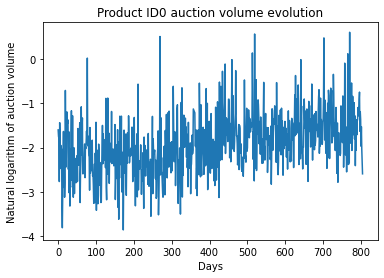

In [ ]:
plt.plot(x,y)
plt.xlabel('Days')
plt.title(label='Product ID0 auction volume evolution');
plt.ylabel('Natural logarithm of auction volume');

## <font color=blue>Forêts aléatoires</font> 

In [ ]:
RF = RandomForestRegressor(n_estimators=100, max_features=4) 

In [ ]:
RF.fit(X_train, np.array(Y_train).ravel())

RandomForestRegressor(max_features=4)

In [ ]:
err(RF)

0.5966639652696304

In [ ]:
trees = [50, 100, 150]
features = [4, 10]

erreur = []
params = []
for elt in itertools.product(trees, features):
    params.append(elt)
    rf = RandomForestRegressor(n_estimators = elt[0], max_features = elt[1])
    rf.fit(X_train, np.array(Y_train).ravel())
    erreur.append(err(rf))

In [ ]:
best_params = params[np.argmin(erreur)]
best_params

(150, 10)

In [ ]:
min(erreur)

0.565565637653353

***On aurait sûrement pu avoir de meilleurs résultats en augmentant ces paramètres, mais rien qu'avec ceux ci-dessus, ça prend énormément de temps, donc on va essayer d'autres méthodes.***

## <font color=blue>Régression linéaire simple</font> 

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(X_train, Y_train)

LinearRegression()

In [ ]:
Y_pred_lr = np.array(lr.predict(X_test)).ravel()
Y_pred_lr

array([-1.67138898, -1.99340439, -1.81624484, ..., -1.58228457,
       -2.03043604, -1.79054582])

In [ ]:
err(lr)

0.5804732329436164

***On visualise les résultats graphiquement:***

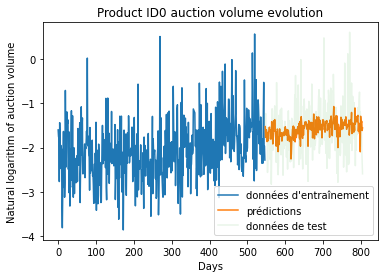

In [ ]:
y = Y_train[X0_train['pid']==0]
x=X_untouched[X_untouched['pid']==0]['day']
b = x[:544]
c = x[544:]
z = Y_pred_lr[X0_test['pid']==0]
w = Y_test[X0_test['pid']==0]
plt.plot(b,y, label = "données d'entraînement")
plt.plot(c,z, label="prédictions")
plt.plot(c,w, alpha = 0.1, label="données de test")
plt.xlabel('Days')
plt.title(label='Product ID0 auction volume evolution')
plt.ylabel('Natural logarithm of auction volume')
plt.legend(loc = "best")

***Les prédictions suivent bien la tendance de l'échantillon test mais ne respectent pas parfaitement les fluctuations. On va donc essayer de prédire les résidus.***

## <font color=blue>Régression linéaire suivie d'une prédiction de résidus</font> 

***L'erreur avec la régression simple toute seule reste assez grande. Les résidus de notre régression sont:***

In [ ]:
Z_train=np.subtract(Y_train, lr.predict(X_train))

In [ ]:
print(Z_train)

           target
ID               
148     -1.051920
149     -0.663647
150     -0.276953
151     -0.416400
152     -0.435529
...           ...
1535728 -0.643293
1535729 -1.011733
1535730 -1.028715
1535731 -0.449816
1535732 -0.268960

[465136 rows x 1 columns]


***La prédiction de résidus se fera sur l'échantillon avec la colonne 'pid' comme dans le benchmark.***

> **<font color=blue>Prédiction des résidus par gradient tree boosting (module XGBoost)</font>** 

In [ ]:
xgbr = xgb.XGBRegressor(n_estimators=100, eta=0.1)

In [ ]:
start_time = time.time()
xgbr.fit(X0_train, Z_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 172.30013704299927 seconds ---


In [ ]:
res = xgbr.predict(X0_test)

In [ ]:
res

array([0.04494978, 0.13071905, 0.14675649, ..., 0.142329  , 0.19582929,
       0.15319863], dtype=float32)

In [ ]:
Y_pred_r = np.array(lr.predict(X_test)).ravel() + res

In [ ]:
print(mean_squared_error(Y_test, Y_pred_r))

0.5144628797814893


> **<font color=blue>Prédiction des résidus par gradient tree boosting (module LightGBM)</font>** 

In [ ]:
lgbr=lgb.LGBMRegressor()

In [ ]:
start_time = time.time()
lgbr.fit(X0_train, Z_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 7.777751922607422 seconds ---


In [ ]:
res = lgbr.predict(X0_test)

In [ ]:
Y_pred_r = np.array(lr.predict(X_test)).ravel() + res

In [ ]:
print(mean_squared_error(Y_test,Y_pred_r))

0.5041948442171924


***Avec la prédiction de résidus, on obtient une erreur plus faible que celle de la régression linéaire toute seule. En plus, on remarque que même sans ajuster les paramètres du régresseur LightGBM, on obtient presque la même erreur que XGBoost mais l'exécution est beaucoup plus rapide, donc on va continue avec LGBMRegressor.***

> **<font color=blue>Ajustement des paramètres du LightGBMRegressor</font>** 

***Pour avoir une meilleure précision avec cette méthode, il faut ajuster le paramètres 'n_estimators' qui doit être élevé mais pas tant que ça pour éviter l'overfitting. Comme on travaille avec un très grand dataset, la méthode GridSearchCV prend beaucoup de temps sans donner de bons résultats. On va donc se contenter d'essayer à chaque fois des paramètres aléatoires jusqu'à optimiser la MSE:***

In [ ]:
trees = list(range(1850,1860))

erreur3 = []
for elt in trees:
    lgbr = lgb.LGBMRegressor(n_estimators = elt)
    lgbr.fit(X0_train, Z_train)
    y = np.array(lr.predict(X_test)).ravel() + lgbr.predict(X0_test)
    erreur3.append(mean_squared_error(Y_test,y))

In [ ]:
best = trees[np.argmin(erreur3)]

In [ ]:
erreur3[np.argmin(erreur3)]

0.4721127193494016

In [ ]:
best

1855

In [ ]:
print("Le meilleur paramètre est : 'n_estimators' = " + str(best))

Les meilleurs paramètres sont : 'n_estimators' = 1855


In [ ]:
print("On a pu diminuer l'erreur de " + str(err(lr)) + " à " + str(erreur3[np.argmin(erreur3)]))

On a pu diminuer l'erreur de 0.5804732329436164 à 0.4721127193494016


***On visualise les résultats graphiquement:***

In [ ]:
lgbr1 = lgb.LGBMRegressor(n_estimators = 1855)
lgbr1.fit(X0_train, Z_train)
Y_pred_lgbr1 = np.array(lr.predict(X_test)).ravel() + lgbr1.predict(X0_test)

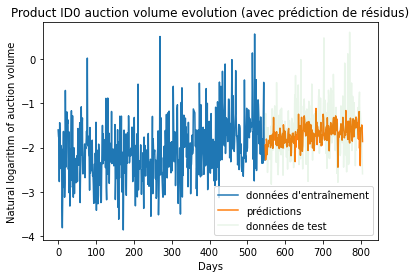

In [ ]:
y = Y_train[X0_train['pid']==0]
x=X_untouched[X_untouched['pid']==0]['day']
b = x[:544]
c = x[544:]
z = Y_pred_lgbr1[X0_test['pid']==0]
w = Y_test[X0_test['pid']==0]
plt.plot(b,y, label = "données d'entraînement")
plt.plot(c,z, label="prédictions")
plt.plot(c,w, alpha = 0.1, label="données de test")
plt.xlabel('Days')
plt.title(label='Product ID0 auction volume evolution (avec prédiction de résidus)')
plt.ylabel('Natural logarithm of auction volume')
plt.legend(loc = "best")

***En essayant d'appliquer cette méthode avec 1855 estimateurs aux données de test du data challenge, l'erreur augmente beaucoup (overfitting) donc on va plutôt agir sur les paramètres 'max_bin' et 'num_leaves'.***

In [ ]:
leaves = [45, 65, 90]
bins= [45, 50, 55, 60]

erreur1 = []
params = []
for elt in itertools.product(leaves, bins):
    params.append(elt)
    lgbr = lgb.LGBMRegressor(num_leaves = elt[0], max_bin = elt[1])
    lgbr.fit(X0_train, Z_train)
    y = np.array(lr.predict(X_test)).ravel() + lgbr.predict(X0_test)
    erreur1.append(mean_squared_error(Y_test,y))

In [ ]:
best_params = params[np.argmin(erreur1)]

In [ ]:
erreur1[np.argmin(erreur1)]

0.4972550291623862

In [ ]:
best_params

(90, 55)

***Clairement, l'erreur est légèrement supérieure à celle qu'on a obtenue avant, mais elle conduit à un meilleur résultat sur les données de test du data challenge.***

## <font color=blue>Feed Forward Networks: réseaux de neurones à propagation avant</font> 

***Pour utiliser les réseaux de neurones, on va centrer et réduire nos données. C'est l'instruction commentée dans la partie "Prétraîtement des données d'entraînement".***

***On va entraîner dans un premier temps un réseau à deux couches cachées avec des paramètres 'hidden_size=32', 'batch_size=32' et 'epochs=10' avant d'optimiser ces paramètres avec une recherche gridsearch.***

In [22]:
input_shape=X.shape[1]

In [ ]:
model=Sequential()
model.add(Dense(64,input_dim=input_shape))
model.add(Activation("relu"))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dense(1))

In [ ]:
model.compile(optimizer="adam",loss='MeanSquaredError')

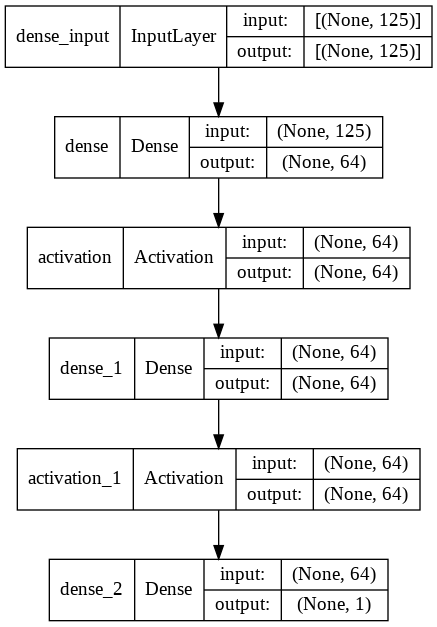

In [ ]:
ks.utils.plot_model(model,show_shapes=True)

In [ ]:
History=model.fit(X_train, Y_train, epochs=10, batch_size=32)

Epoch 1/10
14536/14536 [==============================] - 25s 2ms/step - loss: 0.6418
Epoch 2/10
14536/14536 [==============================] - 24s 2ms/step - loss: 0.5922
Epoch 3/10
14536/14536 [==============================] - 24s 2ms/step - loss: 0.5825
Epoch 4/10
14536/14536 [==============================] - 24s 2ms/step - loss: 0.5765
Epoch 5/10
14536/14536 [==============================] - 24s 2ms/step - loss: 0.5718
Epoch 6/10
14536/14536 [==============================] - 24s 2ms/step - loss: 0.5687
Epoch 7/10
14536/14536 [==============================] - 24s 2ms/step - loss: 0.5661
Epoch 8/10
14536/14536 [==============================] - 24s 2ms/step - loss: 0.5639
Epoch 9/10
14536/14536 [==============================] - 24s 2ms/step - loss: 0.5619
Epoch 10/10
14536/14536 [==============================] - 24s 2ms/step - loss: 0.5607


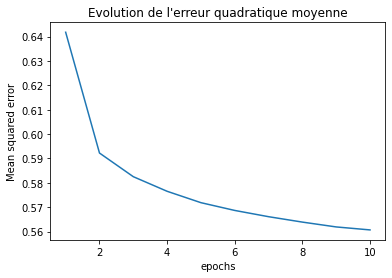

In [ ]:
loss=History.history['loss']
x=np.arange(1,11)
plt.plot(x,loss)
plt.xlabel("epochs")
plt.ylabel("Mean squared error")
plt.title("Evolution de l'erreur quadratique moyenne");

In [ ]:
print(model.evaluate(X_test,Y_test))

6855/6855 [==============================] - 9s 1ms/step - loss: 0.5535
0.5534958243370056


> **<font color=blue>Choix des paramètres</font>** 

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from keras import backend as K

def create_model(hidden_size):
    K.clear_session() #pour vider la mémoire
    model=Sequential()
    model.add(Dense(hidden_size,input_dim=input_shape))
    model.add(Activation("relu"))
    model.add(Dense(hidden_size))
    model.add(Activation("relu"))
    model.add(Dense(1))
    model.compile(optimizer="adam",loss='MeanSquaredError')
    return model

FFN = KerasRegressor(build_fn=create_model)

epochs = [10,20,50]
hidden_size= [32,64,100]
batch_size=[32,64,128]
param_grid = dict(epochs=epochs, hidden_size=hidden_size,batch_size=batch_size )

myfold=TimeSeriesSplit(3)
grid = GridSearchCV(estimator=FFN, param_grid=param_grid,cv=myfold)

<ipython-input-11-320d7460c49d>:17: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  FFN = KerasRegressor(build_fn=create_model)


In [ ]:
result=grid.fit(X,Y,verbose=0)

1337/1337 [==============================] - 1s 801us/step - loss: 0.5690


In [ ]:
print(result.best_params_)

{'batch_size': 32, 'epochs': 20, 'hidden_size': 32}


> **<font color=blue>Application</font>** 

In [23]:
model=Sequential()
model.add(Dense(32,input_dim=input_shape))
model.add(Activation("relu"))
model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dense(1))

In [24]:
model.compile(optimizer="adam",loss='MeanSquaredError')

In [25]:
History=model.fit(X_train, Y_train, epochs=20, batch_size=32)

Epoch 1/20
14536/14536 [==============================] - 25s 2ms/step - loss: 0.6507
Epoch 2/20
14536/14536 [==============================] - 25s 2ms/step - loss: 0.6005
Epoch 3/20
14536/14536 [==============================] - 25s 2ms/step - loss: 0.5915
Epoch 4/20
14536/14536 [==============================] - 25s 2ms/step - loss: 0.5860
Epoch 5/20
14536/14536 [==============================] - 24s 2ms/step - loss: 0.5827
Epoch 6/20
14536/14536 [==============================] - 24s 2ms/step - loss: 0.5804
Epoch 7/20
14536/14536 [==============================] - 24s 2ms/step - loss: 0.5785
Epoch 8/20
14536/14536 [==============================] - 25s 2ms/step - loss: 0.5768
Epoch 9/20
14536/14536 [==============================] - 24s 2ms/step - loss: 0.5753
Epoch 10/20
14536/14536 [==============================] - 24s 2ms/step - loss: 0.5738
Epoch 11/20
14536/14536 [==============================] - 25s 2ms/step - loss: 0.5732
Epoch 12/20
14536/14536 [===========================

In [26]:
print(model.evaluate(X_test,Y_test))

6855/6855 [==============================] - 9s 1ms/step - loss: 0.5693
0.5693082809448242


***On obtient une erreur plus élevée que notre modèle initial.***

> **<font color=blue>Effet de la réduction de dimension</font>** 

***On essaie ici d'appliquer une analyse en composantes principales aux données d'entrée pour essayer d'améliorer les performances du réseau.***

In [27]:
from sklearn.decomposition import PCA
pca=PCA(n_components=64)
X_train_new=pca.fit_transform(X_train)
X_test_new=pca.transform(X_test)

In [28]:
X_train_new.shape

(465136, 64)

In [29]:
model_acp=Sequential()
model_acp.add(Dense(64,input_dim=64))
model_acp.add(Activation("relu"))
model_acp.add(Dense(64))
model_acp.add(Activation("relu"))
model_acp.add(Dense(1))

In [30]:
model_acp.compile(optimizer="adam",loss='MeanSquaredError')

In [31]:
History_acp=model_acp.fit(X_train_new,Y_train,epochs=10,batch_size=32)

Epoch 1/10
14536/14536 [==============================] - 25s 2ms/step - loss: 0.6811
Epoch 2/10
14536/14536 [==============================] - 25s 2ms/step - loss: 0.6457
Epoch 3/10
14536/14536 [==============================] - 25s 2ms/step - loss: 0.6394
Epoch 4/10
14536/14536 [==============================] - 25s 2ms/step - loss: 0.6348
Epoch 5/10
14536/14536 [==============================] - 25s 2ms/step - loss: 0.6320
Epoch 6/10
14536/14536 [==============================] - 25s 2ms/step - loss: 0.6299
Epoch 7/10
14536/14536 [==============================] - 25s 2ms/step - loss: 0.6277
Epoch 8/10
14536/14536 [==============================] - 25s 2ms/step - loss: 0.6264
Epoch 9/10
14536/14536 [==============================] - 25s 2ms/step - loss: 0.6250
Epoch 10/10
14536/14536 [==============================] - 24s 2ms/step - loss: 0.6236


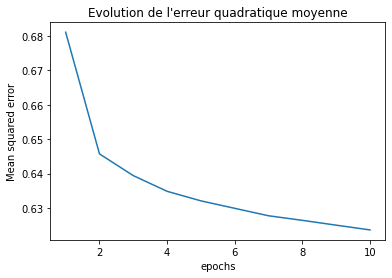

In [32]:
loss=History_acp.history['loss']
x=np.arange(1,11)
plt.plot(x,loss)
plt.xlabel("epochs")
plt.ylabel("Mean squared error")
plt.title("Evolution de l'erreur quadratique moyenne");

In [33]:
print(model_acp.evaluate(X_test_new,Y_test))

6855/6855 [==============================] - 9s 1ms/step - loss: 0.9859
0.985852062702179


***Dans notre cas, la réduction de dimension n'est pas optimale.***

## <font color=blue>Réseaux LSTM</font> 

***Avant d'entraîner le modèle, il faut remettre les données d'entrée sous la forme d'un tableau à trois dimensions pour pouvoir les passer en entrée à la couche LSTM.***

In [35]:
(x0,y0)=X_train.shape
(x1,y1)=X_test.shape

In [37]:
trainX=X_train.to_numpy().reshape(x0,1,y0)
testX=X_test.to_numpy().reshape(x1,1,y1)

> **<font color=blue>Réseau LSTM pur</font>** 

In [38]:
lstm=Sequential()
lstm.add(LSTM(64, input_shape=(1, y0), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')

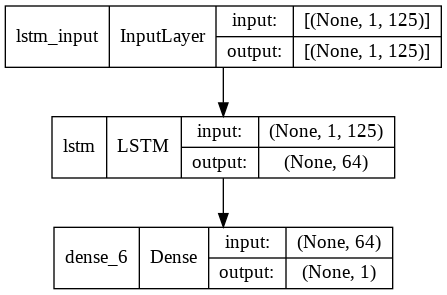

In [39]:
ks.utils.plot_model(lstm,show_shapes=True)

In [40]:
history=lstm.fit(trainX, Y_train, epochs=10, batch_size=32)

Epoch 1/10
14536/14536 [==============================] - 41s 3ms/step - loss: 0.6605
Epoch 2/10
14536/14536 [==============================] - 39s 3ms/step - loss: 0.5885
Epoch 3/10
14536/14536 [==============================] - 39s 3ms/step - loss: 0.5770
Epoch 4/10
14536/14536 [==============================] - 39s 3ms/step - loss: 0.5682
Epoch 5/10
14536/14536 [==============================] - 39s 3ms/step - loss: 0.5624
Epoch 6/10
14536/14536 [==============================] - 40s 3ms/step - loss: 0.5569
Epoch 7/10
14536/14536 [==============================] - 39s 3ms/step - loss: 0.5525
Epoch 8/10
14536/14536 [==============================] - 40s 3ms/step - loss: 0.5487
Epoch 9/10
14536/14536 [==============================] - 40s 3ms/step - loss: 0.5457
Epoch 10/10
14536/14536 [==============================] - 39s 3ms/step - loss: 0.5432


In [41]:
mean_squared_error(lstm.predict(testX),Y_test)

0.5639765039376825

***Le résultat est moins précis qu'un réseau à propagation avant.***

> **<font color=blue>Réseau avec une couche LSTM et deux couches Dense</font>** 

In [42]:
model=Sequential()
model.add(LSTM(64, input_shape=(1, y0), activation='relu', return_sequences=False))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

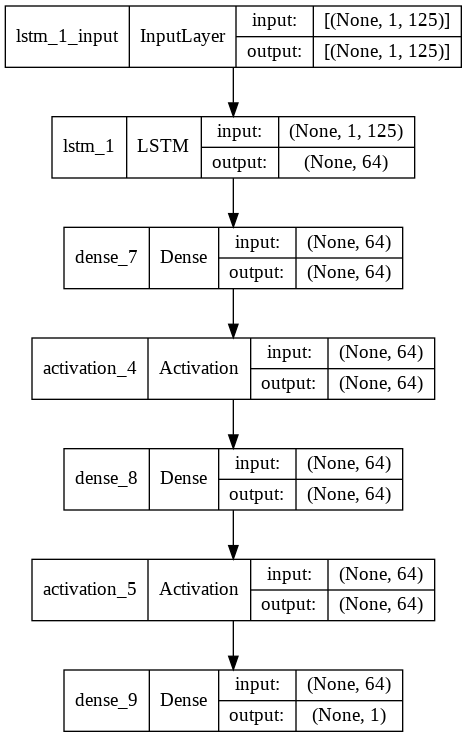

In [43]:
ks.utils.plot_model(model,show_shapes=True)

In [44]:
history=model.fit(trainX, Y_train, epochs=10, batch_size=128, verbose=1)

Epoch 1/10
3634/3634 [==============================] - 18s 5ms/step - loss: 0.6461
Epoch 2/10
3634/3634 [==============================] - 16s 4ms/step - loss: 0.5849
Epoch 3/10
3634/3634 [==============================] - 16s 5ms/step - loss: 0.5736
Epoch 4/10
3634/3634 [==============================] - 16s 5ms/step - loss: 0.5645
Epoch 5/10
3634/3634 [==============================] - 17s 5ms/step - loss: 0.5575
Epoch 6/10
3634/3634 [==============================] - 16s 4ms/step - loss: 0.5519
Epoch 7/10
3634/3634 [==============================] - 16s 4ms/step - loss: 0.5464
Epoch 8/10
3634/3634 [==============================] - 17s 5ms/step - loss: 0.5422
Epoch 9/10
3634/3634 [==============================] - 17s 5ms/step - loss: 0.5382
Epoch 10/10
3634/3634 [==============================] - 16s 4ms/step - loss: 0.5351


In [45]:
print(model.evaluate(testX,Y_test))

6855/6855 [==============================] - 11s 2ms/step - loss: 0.5560
0.5559967756271362


## <font color=blue>Prédiction séparée par pid</font> 

***On a essayé ici d'isoler chaque 'pid' et réaliser une régression linéaire sur les données qui le concernent. On prédit alors la sortie pour tous les pid avant de remettre le tout en ordre.***

In [ ]:
LXt = [Xt[Wt['pid']==id] for id in PID]
LWt = [Wt[Wt['pid']==id] for id in PID]

> **<font color=blue>Par régression linéaire simple</font>** 

***On essaie d'abord cette méthode sur nos échantillons train et test.***

In [ ]:
Y_pred1=[]
for i in range(len(LX_train)):
  model=LinearRegression()
  model.fit(LX_train[i],LY_train[i])
  df=pd.DataFrame(model.predict(LX_test[i]),index=LX_test[i].index,columns=['target'])
  Y_pred1.append(df)

In [ ]:
Y_p=pd.concat(Y_pred1)
Y_p=Y_p.sort_index()

In [ ]:
mean_squared_error(Y_p, Y_test)

0.5639306543912981

***On essaie ensuite sur l'échantillon test du challenge.***

In [ ]:
Y_pred2=[]
for i in range(len(LX_train)):
  model=LinearRegression()
  model.fit(LX[i],LY[i])
  df=pd.DataFrame(model.predict(LXt[i]),index=LXt[i].index,columns=['target'])
  Y_pred2.append(df)

In [ ]:
submission=pd.concat(Y_pred2)
submission=submission.sort_index()

In [ ]:
submission.to_csv("/Users/ayaamenssag/Desktop/predseparee.csv")

***Avec cette méthode, on a obtenu une erreur de 0.58 avec l'échantillon test du challenge, qui est assez proche de l'erreur sur notre propre échantillon test (0.56) contrairement aux méthodes précédentes. Ceci est peut-être dû au fait qu'on a prédit sur des sous-échantillons de taille réduite ce qui a amélioré la précision.***

> **<font color=blue>Par régression linéaire suivie de prédiction de résidus par LGBMRegressor</font>** 

***Pour essayer de 'parfaire' cette méthode de prédiction segmentée, on va appliquer, en plus de la régression linéaire, une prédiction de résidus vu qu'on avait obtenus des erreurs réduites auparavant.***

***On essaie d'abord sur nos échantillons train et test.***

In [ ]:
LZ_train =[]
for i in range(len(LX_train)):
    model=LinearRegression()
    model.fit(LX_train[i],LY_train[i])
    Z_train = np.subtract(LY_train[i], lr.predict(LX_train[i]))
    LZ_train.append(Z_train)

In [ ]:
Y_pred3 = []
for i in range(len(LX_train)):
    lgbr = lgb.LGBMRegressor(n_estimators = 1855)
    lgbr.fit(LX0_train[i], LZ_train[i])
    y = np.array(lr.predict(LX_test[i])).ravel() + lgbr.predict(LX0_test[i])
    df=pd.DataFrame(y, index=LX_test[i].index,columns=['target'])
    Y_pred3.append(df)

In [ ]:
Y_p3=pd.concat(Y_pred3)
Y_p3=Y_p3.sort_index()

In [ ]:
mean_squared_error(Y_p3, Y_test)

0.4555753296212613

***On essaie ensuite sur l'échantillon test du challenge.***

In [ ]:
LZ =[]
for i in range(len(LX_train)):
    model=LinearRegression()
    model.fit(LX[i],LY[i])
    Z = np.subtract(LY[i], lr.predict(LX[i]))
    LZ.append(Z)

In [ ]:
Y_pred4 = []
for i in range(len(LX_train)):
    lgbr = lgb.LGBMRegressor(n_estimators = 1855)
    lgbr.fit(LX0[i], LZ[i])
    y = np.array(lr.predict(LXt[i])).ravel() + lgbr.predict(LWt[i])
    df=pd.DataFrame(y, index=LXt[i].index,columns=['target'])
    Y_pred4.append(df)

In [ ]:
Y_p4=pd.concat(Y_pred4)
Y_p4=Y_p4.sort_index()

In [ ]:
submission = Y_p4

In [ ]:
submission.to_csv("/Users/ayaamenssag/Desktop/predsepareeaveclgbr.csv")